In [26]:
from IPython.display import display
from scipy.stats import pearsonr
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='svg'

In [3]:
sample=pd.read_csv('results-2021-12-18.csv')

## Task 1

In [8]:
def generate_dataframe(algorithm,sample):
    x_line,y_line,energy,Name=[],[],[],[]
    #sample_groupby=sample[sample['algorithm']==name].groupby(sample['experiment_id'])
    sample_groupby=sample.groupby(sample['experiment_id'])
    for experimentID,group in sample_groupby:
        #print('experimentID:',experimentID,'   lenth:',len(group),)
        #print(group['train_energy(J)'].mean())
        #display(group[:10][['no_datapoints','no_features','train_energy(J)']])#group[['algorithm','RQ','train_energy(J)']])
        #display(group['no_datapoints'].iloc[0],group['no_features'].iloc[0])
        if group['no_features'].iloc[0]==8169:
            x_line.append(group['no_datapoints'].iloc[0])
            y_line.append(group['no_features'].iloc[0])
            energy.append(group['train_energy(J)'].mean())
            Name.append(group['algorithm'].iloc[0])
    x_line=pd.Series(x_line)
    y_line=pd.Series(y_line)
    energy=pd.Series(energy)
    Name=pd.Series(Name)
    df=pd.concat([x_line,y_line,energy,Name],axis=1) #将多个拥有相同的index的等长Series合并成一个Dataframe
    #df=pd.concat([x_line,energy,Name],axis=1)
    df.columns=['no_datapoints','no_features','train_energy','algorithm']
    #df.columns=['no_datapoints','train_energy','algorithm']
    df=df.drop_duplicates(subset=['no_datapoints', 'no_features','algorithm'], keep='first')
    return df

In [9]:
df=generate_dataframe('SVM',sample).drop_duplicates()
DF = df[['no_datapoints','algorithm','train_energy']].pivot(index='algorithm',columns='no_datapoints',values='train_energy')

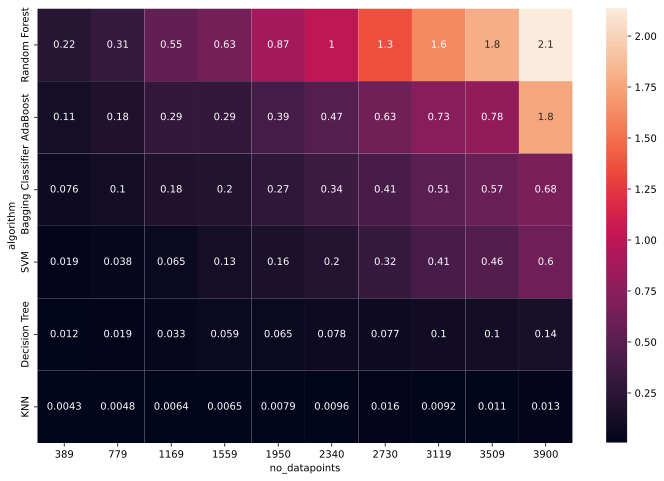

In [10]:
plt.figure(figsize=(12,8))
DF=DF.sort_values(by=3900,ascending=False)
plt.yticks(rotation=90)
ax=sns.heatmap(DF,annot=True)#,linewidths=.2)

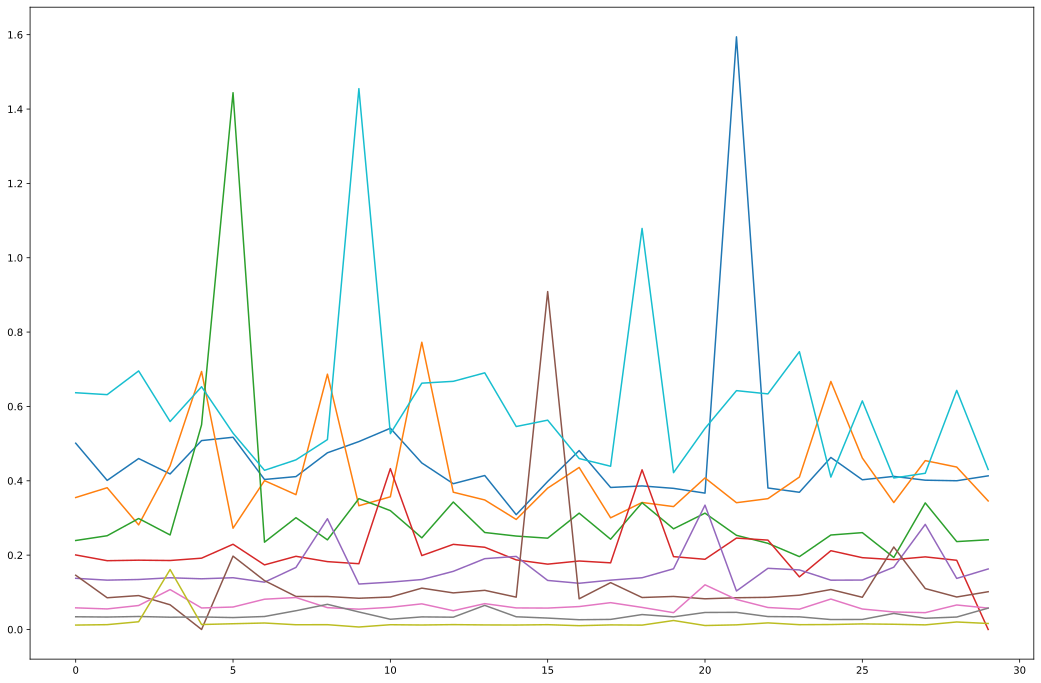

In [11]:
plt.figure(figsize=(18,12))
#figure,axes=plt.subplots()
id_groupby=sample.groupby(sample['experiment_id'])
for times,total in enumerate(id_groupby):
    name1,group1 = total
    if times==10: break
    #iteration_groupby=group1.groupby(group1['iteration'])
    #display(name1,group1['train_energy(J)'])
    times+=1
    sns.lineplot(x=range(30),y=group1['train_energy(J)'].values)

## Task 2

In [12]:
#设计一个函数
#输入：算法的名称，RQ(实验种类)
#返回：一个dataframe包含no_features,train_engergy(J)两个字段

def basic_process(dataset:pd.core.frame.DataFrame,_type,algorithm=None,column=['no_features','train_energy(J)']):
    result_list=list()
    if not algorithm: algorithm=list(dataset['algorithm'].unique())
    groupby_algorithm=dataset.query(f'RQ=={_type} and algorithm == {algorithm}').groupby(dataset['algorithm'])
    for name_group in groupby_algorithm: result_list.append(name_group[1])
    return pd.concat(result_list)#[column]

In [18]:
#这是一个画带置信区间折线图的函数
#输入：一个dataframe，横轴字段，纵轴字段
#输出：一张图

def draw_linepolt_withCI(resource:pd.core.frame.DataFrame,x_axis='no_features',y_axis='train_energy(J))'):
    plt.figure(figsize=(9,6))
    sns.lineplot(data=resource,x=x_axis,y=y_axis)

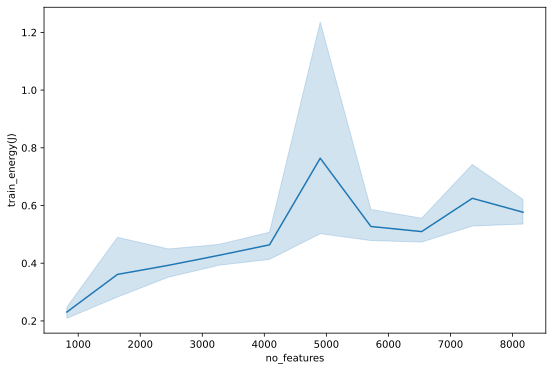

In [19]:
Parameters={
    'resource':basic_process(dataset=sample,algorithm=['SVM'],_type=2.2),
    'x_axis':'no_features',
    'y_axis':"train_energy(J)"
}
draw_linepolt_withCI(**Parameters)

## Task 3

In [21]:
def advance_process(dataset:pd.core.frame.DataFrame):
    field,result_list=list(dataset.columns),list()
    group_id=dataset.groupby(dataset['experiment_id'])
    for name_group in group_id:
        #display(name_group[1].mean())
        Mean_series=name_group[1].mean()
        Mean_dataframe=pd.DataFrame(Mean_series).T
        Mean_dataframe['algorithm']=name_group[1]['algorithm'].iloc[0]
        result_list.append(Mean_dataframe)
        #display(pd.DataFrame(Mean_series.values,Mean_series.index))
        #display(pd.Series.to_frame(Mean_series))
        #pd.DataFrame(name_group[1].mean())
    return pd.concat(result_list)

In [36]:
#编写一个函数，根据数据集和所选字段绘制若干子图
#输入：数据集，要用来当x，y轴的字段
#返回：绘制一系列图

def multiplot(dataset:pd.core.frame.DataFrame,xaxis,yaxis,subplot):
    dataset=dataset.sort_values(by=xaxis)
    grid = sns.FacetGrid(dataset, col=subplot, hue=subplot, palette="tab20c",col_wrap=6, height=3)
    grid.map(plt.plot, xaxis, yaxis, marker="o")
    grid.fig.tight_layout(w_pad=2)

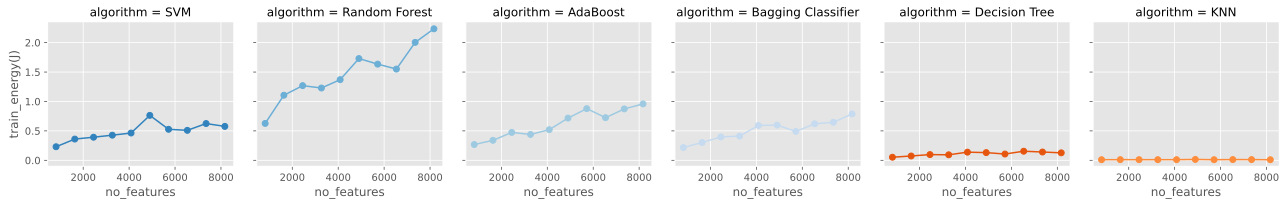

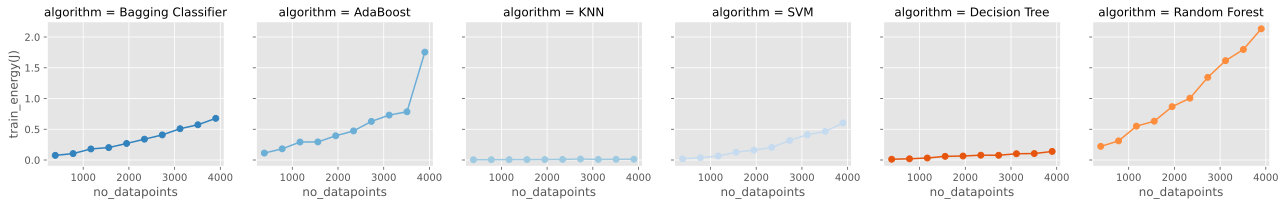

In [37]:
Parameters={
    "dataset":advance_process(basic_process(sample,_type=2.2)),
    "xaxis":"no_features",#"no_datapoints",
    "yaxis":"train_energy(J)",#"train_energy(J)",#"accuracy",#"train_energy(J)",
    "subplot":"algorithm"
}
multiplot(**Parameters)

Parameters={
    "dataset":advance_process(basic_process(sample,_type=2.1)),
    "xaxis":"no_datapoints",#"no_datapoints",
    "yaxis":"train_energy(J)",#"train_energy(J)",#"accuracy",#"train_energy(J)",
    "subplot":"algorithm"
}
multiplot(**Parameters)

## Task 4

In [24]:
#这是一个计算df中两列相关系数的函数
#输入：一个数据集（df），要算相关系数的两列
#返回：一个Series，index是算法名，另一列是相关系数

def cal_Relevant(dataset:pd.core.frame.DataFrame,factor_1:str,factor_2:str):
    result=pd.Series(float)
    for algorithm in dataset['algorithm'].unique():
        tempory=dataset[dataset['algorithm']==algorithm]
        result[algorithm]=pearsonr(tempory[factor_1],tempory[factor_2])[0]
    return result[1:]

In [27]:
fea_rev=cal_Relevant(basic_process(sample,_type=2.2),'no_features','train_energy(J)')
dp_rev=cal_Relevant(basic_process(sample,_type=2.1),'no_datapoints','train_energy(J)')

In [32]:
Keys=['features with energy']
keys=['datapoints with energy']
a=Keys*6
a.extend(keys*6)
Height=[0.9,0.7,0.5,0.3,0.1]
Type=['Highly linear correlation','Significant linear correlation','Moderate linear correlation',
  'Low linearity correlation','No linear correlation']

In [29]:
test=pd.concat([fea_rev,dp_rev],axis=0)
test=pd.DataFrame(test)
test['algorithm']=test.index
Keys=['features with energy','datapoints and energy']
test['RQ']=a
test=test.rename(columns={0:"Correlation coefficient"})

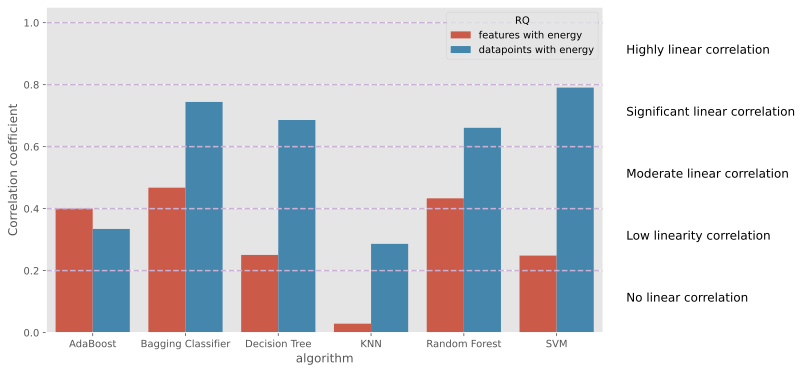

In [38]:
#plt.style.use('ggplot')
plt.figure(figsize=(10,6))
sns.barplot(data=test, x='algorithm', y='Correlation coefficient', hue='RQ')
for y_height,Text,height in zip(Height,Type,[0.2,0.4,0.6,0.8,1.0]):
    plt.text(5.75,y_height,Text,fontsize=12)
    plt.axhline(y=height,color=sns.color_palette("Paired")[8],linestyle='--')